Source: https://firms.modaps.eosdis.nasa.gov

- Latitude 	Latitude 	Center of nominal 375 m fire pixel.

- Longitude 	Longitude 	Center of nominal 375 m fire pixel.

- Bright_ti4 	Brightness temperature I-4 	VIIRS I-4 channel brightness temperature of the fire pixel measured in Kelvin.

- Scan 	Along Scan pixel size 	The algorithm produces approximately 375 m pixels at nadir. Scan and track reflect actual pixel size.

- Track 	Along Track pixel size 	The algorithm produces approximately 375 m pixels at nadir. Scan and track reflect actual pixel size.

- Acq_Date 	Acquisition Date 	Date of VIIRS acquisition.

- Acq_Time 	Acquisition Time 	Time of acquisition/overpass of the satellite (in UTC).

- Satellite 	Satellite 	N= Suomi National Polar-orbiting Partnership (Suomi NPP).

- Confidence 	Confidence 	

    This value is based on a collection of intermediate algorithm quantities used in the detection process. It is intended to help users gauge the quality of individual hotspot/fire pixels. Confidence values are set to **low, nominal, and high**. Low confidence daytime fire pixels are typically associated with areas of Sun glint and lower relative temperature anomaly (<15 K) in the mid-infrared channel I4. Nominal confidence pixels are those free of potential Sun glint contamination during the day and marked by strong (>15 K) temperature anomaly in either day or nighttime data. High confidence fire pixels are associated with day or nighttime saturated pixels.

    Please note: Low confidence nighttime pixels occur only over the geographic area extending from 11° E to 110° W and 7° N to 55° S. This area describes the region of influence of the South Atlantic Magnetic Anomaly which can cause spurious brightness temperatures in the mid-infrared channel I4 leading to potential false positive alarms. These have been removed from the NRT data distributed by FIRMS.

- Version 	Version (collection and source) 	

    Version identifies the collection (e.g., VIIRS Collection 1 or VIIRS Collection 2), and source of data processing (Ultra Real-Time (URT suffix added to collection), Real-Time (RT suffix), Near Real-Time (NRT suffix) or Standard Processing (collection only). For example:

    "2.0URT" - Collection 2 Ultra Real-Time processing.
    
    "2.0RT" - Collection 2 Real-Time processing.
    
    "1.0NRT" - Collection 1 Near Real-Time processing.
    
    "1.0" - Collection 1 Standard processing.
    
- Bright_ti5 	

    Brightness temperature I-5 	I-5 Channel brightness temperature of the fire pixel measured in Kelvin.

- FRP 	Fire Radiative Power 	

    FRP depicts the pixel-integrated fire radiative power in megawatts (MW). Given the unique spatial and spectral resolution of the data, the VIIRS 375 m fire detection algorithm was customized and tuned to optimize its response over small fires while balancing the occurrence of false alarms. Frequent saturation of the mid-infrared I4 channel (3.55-3.93 µm) driving the detection of active fires requires additional tests and procedures to avoid pixel classification errors. As a result, sub-pixel fire characterization (e.g., fire radiative power [FRP] retrieval) is only viable across small and/or low-intensity fires. Systematic FRP retrievals are based on a hybrid approach combining 375 and 750 m data. In fact, starting in 2015 the algorithm incorporated additional VIIRS channel M13 (3.973-4.128 µm) 750 m data in both aggregated and unaggregated format.

- Type* 	Inferred hot spot type 	

    0 = presumed vegetation fire
    
    1 = active volcano

    2 = other static land source

    3 = offshore detection (includes all detections over water)

- DayNight 	Day or Night 	

D= Daytime fire, N= Nighttime fire


In [125]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import matplotlib as plt
from shapely.geometry import Point, Polygon
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union
import plotly.graph_objects as go
from shapely.geometry import MultiPoint, box

In [126]:
df_archive = pd.read_csv('./data/fire_archive_SV-C2_409232.csv')
df_archive.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,-23.362709,-67.729622,310.99,0.54,0.42,2013-12-12,518,N,VIIRS,n,1,273.37,2.52,N,0
1,-23.363398,-67.732323,300.95,0.54,0.42,2013-12-12,518,N,VIIRS,n,1,271.59,2.57,N,0
2,-23.779940,-70.316292,301.24,0.49,0.49,2013-12-12,524,N,VIIRS,n,1,286.47,1.40,N,2
3,-23.784391,-70.317360,298.73,0.49,0.49,2013-12-12,524,N,VIIRS,n,1,285.13,1.14,N,2
4,-23.822016,-70.315941,299.23,0.49,0.49,2013-12-12,524,N,VIIRS,n,1,287.12,1.61,N,2


In [127]:
df_archive.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,260113.0,-34.917535,5.035206,-53.971592,-38.003956,-36.096428,-33.993744,-17.638351
longitude,260113.0,-71.734589,1.631926,-109.434303,-72.495735,-71.939209,-70.954895,-67.057037
brightness,260113.0,332.314128,20.478540,208.000000,316.680000,334.450000,345.690000,367.000000
scan,260113.0,0.464194,0.090212,0.320000,0.400000,0.440000,0.510000,0.800000
track,260113.0,0.488595,0.118107,0.360000,0.380000,0.450000,0.580000,0.780000
acq_time,260113.0,1300.453972,644.766414,330.000000,548.000000,1754.000000,1848.000000,2200.000000
version,260113.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
bright_t31,260113.0,295.325539,13.913195,215.700000,285.800000,293.690000,303.210000,380.000000
frp,260113.0,14.530937,35.583886,0.050000,2.390000,5.060000,11.870000,1502.760000
type,260113.0,0.400845,0.837102,0.000000,0.000000,0.000000,0.000000,3.000000


In [128]:
df_archive['satellite'].value_counts()

N    260113
Name: satellite, dtype: int64

In [129]:
df_archive['confidence'].value_counts()

n    222000
h     20609
l     17504
Name: confidence, dtype: int64

In [130]:
df_archive['daynight'].value_counts()

D    149775
N    110338
Name: daynight, dtype: int64

In [131]:
df_archive['type'].value_counts()

0    209756
2     41924
3      5992
1      2441
Name: type, dtype: int64

In [132]:
df_archive['acq_date'] = pd.to_datetime(df_archive['acq_date'])

In [133]:
with open('./token.txt', 'r') as f:
    TOKEN = f.read()
    px.set_mapbox_access_token(TOKEN)

In [280]:
a = df_archive[['acq_date', 'brightness', 'confidence', 'frp', 'type', 'daynight', 'bright_t31']].copy()
a['year'] = a['acq_date'].dt.year
a['month'] = a['acq_date'].dt.month
a['date'] = a['acq_date'].dt.date
a['year-month'] = a['acq_date'].dt.to_period('M').astype(str)
a = a.groupby(['acq_date', 'type', 'confidence'])['frp', 'brightness', 'bright_t31'].max().reset_index()
a = a[a['type'] == 0]
a = a[a['frp'] > 100]
px.line(a, x='acq_date', y='frp', color='confidence')

/tmp/ipykernel_24344/300799513.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [135]:
px.line(a, x='year-month', y='brightness', color='confidence')

In [136]:
px.line(a, x='year-month', y='bright_t31', color='confidence')

In [137]:
a = df_archive[['acq_date', 'brightness', 'confidence', 'frp', 'type', 'daynight', 'bright_t31']].copy()
a['year'] = a['acq_date'].dt.year
a['month'] = a['acq_date'].dt.month
a['year-month'] = a['acq_date'].dt.to_period('M').astype(str)
a = a.groupby(['acq_date', 'type', 'confidence', "daynight"])['frp'].count().reset_index()
a = a[a['type'] == 0]
a = a[a['confidence'] == "n"]
px.line(a, x='acq_date', y='frp', color="daynight", title="Count of fires")

In [138]:
a = df_archive[['latitude', 'longitude', 'acq_date', 'acq_time', 'frp', 'type', 'confidence', 'scan', 'track']].copy()
a['year'] = a['acq_date'].dt.year
a['month'] = a['acq_date'].dt.month
a = a.groupby(['latitude', 'longitude', 'year', 'type', 'confidence', 'track', 'month'])['frp'].mean().reset_index()
a = a.sort_values(by='year', ascending=True)
a = a[a['type'] == 0]
#a = a[~(a['confidence'] == 'l')]
a = a[(a['confidence'] == 'h')]
fig = px.scatter_mapbox(a, lat="latitude", lon="longitude", animation_frame='year', color="frp", size='frp', zoom=3, title='Emmissions')
fig.update_layout(mapbox_style='satellite', title='Emissions', height=800)
fig.show()

In [139]:
# Number of fires
b = a.groupby(['year'])['frp'].count().reset_index()
px.bar(b, x='year', y='frp')    

MBR

In [200]:
b = a[a['year'] == 2017].copy()

coords = b[['latitude', 'longitude']].values

clustered_data = pd.DataFrame()
mbr_data = pd.DataFrame()

min_samples = 5
epsilon = 0.018

for year in b['year'].unique():
    for month in b['month'].unique():
        subset = b[(b['year'] == year) & (b['month'] == month)
                   ][['latitude', 'longitude', 'frp']]

        if len(subset) >= min_samples:
            db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(
                subset[['latitude', 'longitude']])
            print(year, month, np.unique(db.labels_))
            subset['cluster'] = db.labels_
            subset['month'] = month
            subset['year'] = year

            # Get the MBR data
            for cluster_label in np.unique(db.labels_):
                if cluster_label == -1:
                    continue
                cluster_points = subset[subset['cluster'] ==
                                        cluster_label][['latitude', 'longitude']]
                mbr = MultiPoint(cluster_points.values).envelope
                #print(mbr)
                min_lat, min_lon, max_lat, max_lon = mbr.bounds
                mbr_df = pd.DataFrame({
                    'month': [month],
                    'year': [year],
                    'cluster': [cluster_label],
                    'mbr': [mbr],
                    'total_frp': subset[subset['cluster'] == cluster_label]['frp'].sum(),
                    'mean_frp': subset[subset['cluster'] == cluster_label]['frp'].mean(),
                    'max_frp': subset[subset['cluster'] == cluster_label]['frp'].max()
                })
                mbr_data = pd.concat([mbr_data, mbr_df], axis=0)
            clustered_data = pd.concat(
                [clustered_data, subset], ignore_index=True)

fig.update_layout(
    mapbox_style='satellite',
    title='Fires Clustered by DBSCAN',
    height=800
)

# Show the plot
fig.show()

2017 1 [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112]
2017 2 [-1  0  1  2  3  4  5  6  7]
2017 3 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34]
2017 4 [-1  0]
2017 11 [-1  0  1]
2017 9 [-1  0]
2017 10 [-1]
2017 5 [-1]
2017 8 [-1]
2017 7 [-1]
2017 12 [-1  0  1]


In [201]:
mbr_data.reset_index(drop=True, inplace=True)
mbr_data.head()

,month,year,cluster,mbr,total_frp,mean_frp,max_frp
0,1,2017,0,"POLYGON ((-36.637066 -72.872658, -36.587902 -7...",5396.54,71.953867,306.10
1,1,2017,1,"POLYGON ((-34.982723 -72.001427, -34.713955 -7...",56099.70,79.800427,655.81
2,1,2017,2,"POLYGON ((-35.046936 -71.682945, -35.018074 -7...",210.54,15.038571,35.02
3,1,2017,3,"POLYGON ((-36.93576 -72.800453, -36.578148 -72...",23407.60,50.886087,369.31
4,1,2017,4,"POLYGON ((-35.468372 -72.364029, -35.335815 -7...",16064.61,121.701591,901.58


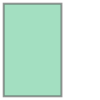

In [203]:
mbr_data.loc[0]['mbr']

In [247]:
geo_df = gpd.GeoDataFrame(geometry=mbr_data['mbr'], data=mbr_data.drop(columns=['mbr']))

In [269]:
fig = px.scatter_mapbox(
    clustered_data[clustered_data['month'] == 1],
    lat="latitude",
    lon="longitude",
    color="frp",
    #animation_frame='month',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=5,
    title='Fires Clustered by DBSCAN'
)


def scale_value(value, min_val, max_val):
    scaled_value = 255 * (value - min_val) / (max_val - min_val)
    return int(scaled_value)

min_val = geo_df['max_frp'].min()
max_val = geo_df['max_frp'].max()

for i, row in geo_df[geo_df['month'] == 1].iterrows():
    min_lat, min_lon, max_lat, max_lon = row['geometry'].bounds
    fill_val = scale_value(row['max_frp'], min_val, max_val)

    rectangle = go.Scattermapbox(
        lat=[min_lat, max_lat, max_lat, min_lat, min_lat],
        lon=[min_lon, min_lon, max_lon, max_lon, min_lon],
        mode="lines",
        line=dict(color='white'),
        fill='toself',
        fillcolor=f'rgba({fill_val}, {(255-fill_val)%255}, {(255-fill_val)%255}, 0.3)',
        showlegend=False
    )
    fig.add_trace(rectangle)

fig.update_layout(
    mapbox_style='satellite',
    title='Fires Clustered by DBSCAN',
    height=800
)

# Show the plot
fig.show()

### Some questions arises:
- Are there some repeating clusters every fire season? by which time granularity?

- If not many, is that because of the lack of material to feed the fires? 

    - how much time would have to pass for a certain fire to repeat in the same place?

In [ ]:
# Return both clusters MBR if they intersect

In [290]:
a = df_archive.copy()
data = a['acq_time'].unique()
data.sort()
data

array([ 330,  336,  342,  348,  354,  400,  406,  412,  418,  424,  430,
        436,  442,  448,  454,  500,  506,  512,  518,  524,  530,  536,
        542,  548,  554,  600,  606,  612,  618,  624,  630,  636,  642,
        648,  654,  700,  706,  724,  736,  748,  800,  806,  812,  818,
        824,  830,  836,  842,  848,  906, 1712, 1718, 1724, 1730, 1736,
       1742, 1748, 1754, 1800, 1806, 1812, 1818, 1824, 1830, 1836, 1842,
       1848, 1854, 1900, 1906, 1912, 1918, 1924, 1930, 1936, 1942, 1948,
       1954, 2000, 2006, 2012, 2018, 2024, 2030, 2036, 2042, 2048, 2054,
       2100, 2106, 2112, 2118, 2124, 2130, 2136, 2142, 2148, 2200])

### More Analysis
- Difference between reported fires vs detected fires by NASA.

### TODO

- Scrape Drought, Rain, Sun data from Meteochile and analyze with fire data.